In [55]:
import pandas as pd 
import mysql.connector
import os
import numpy as np
import missingno as msno
from textblob import TextBlob
import re
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.snowball import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from PIL import Image

stemmer = SnowballStemmer("english")

In [2]:
conn = mysql.connector.connect(user='root', password='123456', host='127.0.0.1', 
                              database = 'purl_wordpress_to_anonimize')
comments = pd.read_sql('SELECT * from jux0gx_comments', con=conn)

In [3]:
comments.head()

,comment_ID,comment_post_ID,comment_author,comment_author_email,comment_author_url,comment_author_IP,comment_date,comment_date_gmt,comment_content,comment_karma,comment_approved,comment_agent,comment_type,comment_parent,user_id
0,2,23,emily p,,,70.44.66.3,2014-07-24 12:54:46,2014-07-24 12:54:46,These are fantastic! I have been looking for s...,0,1,,,0,0
1,3,23,Lena,lena.mumen@gmail.com,http://www.mrsgarlichead.com,85.1.237.251,2014-07-24 13:24:02,2014-07-24 13:24:02,"Oh these are lovely. I love the tulip hem, I h...",0,1,,,0,0
2,4,23,Katie,,,72.198.169.59,2014-07-24 15:33:46,2014-07-24 15:33:46,Love these shorts!! This may be a silly questi...,0,1,,,0,0
3,5,23,jessica,,,76.114.88.227,2014-07-24 15:46:05,2014-07-24 15:46:05,"so sad, yet another pattern not big enough for...",0,1,,,0,0
4,6,23,"Margo, Thrift at Home",thriftathome@gmail.com,http://thriftathome.blogspot.com,108.55.66.48,2014-07-24 18:19:31,2014-07-24 18:19:31,YES I am done with the gym!!! This year I&#39;...,0,1,,,0,0


In [4]:
conn.close()

In [5]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52845 entries, 0 to 52844
Data columns (total 15 columns):
comment_ID              52845 non-null int64
comment_post_ID         52845 non-null int64
comment_author          52845 non-null object
comment_author_email    52845 non-null object
comment_author_url      52845 non-null object
comment_author_IP       52845 non-null object
comment_date            52704 non-null datetime64[ns]
comment_date_gmt        52698 non-null datetime64[ns]
comment_content         52845 non-null object
comment_karma           52845 non-null int64
comment_approved        52845 non-null object
comment_agent           52845 non-null object
comment_type            52845 non-null object
comment_parent          52845 non-null int64
user_id                 52845 non-null int64
dtypes: datetime64[ns](2), int64(5), object(8)
memory usage: 6.0+ MB


In [6]:
comments['comment_approved'].unique()

array(['1', 'post-trashed', 'trash', '0', 'spam'], dtype=object)

In [7]:
print(comments.groupby('comment_approved').size())

comment_approved
0                  19
1               52363
post-trashed        6
spam              193
trash             264
dtype: int64


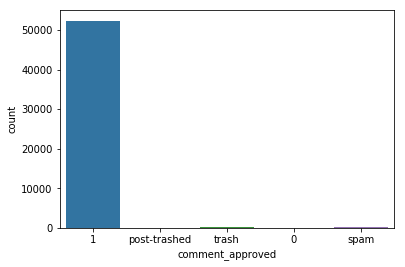

In [8]:
sns.countplot(comments['comment_approved'], label='Count')
plt.show()

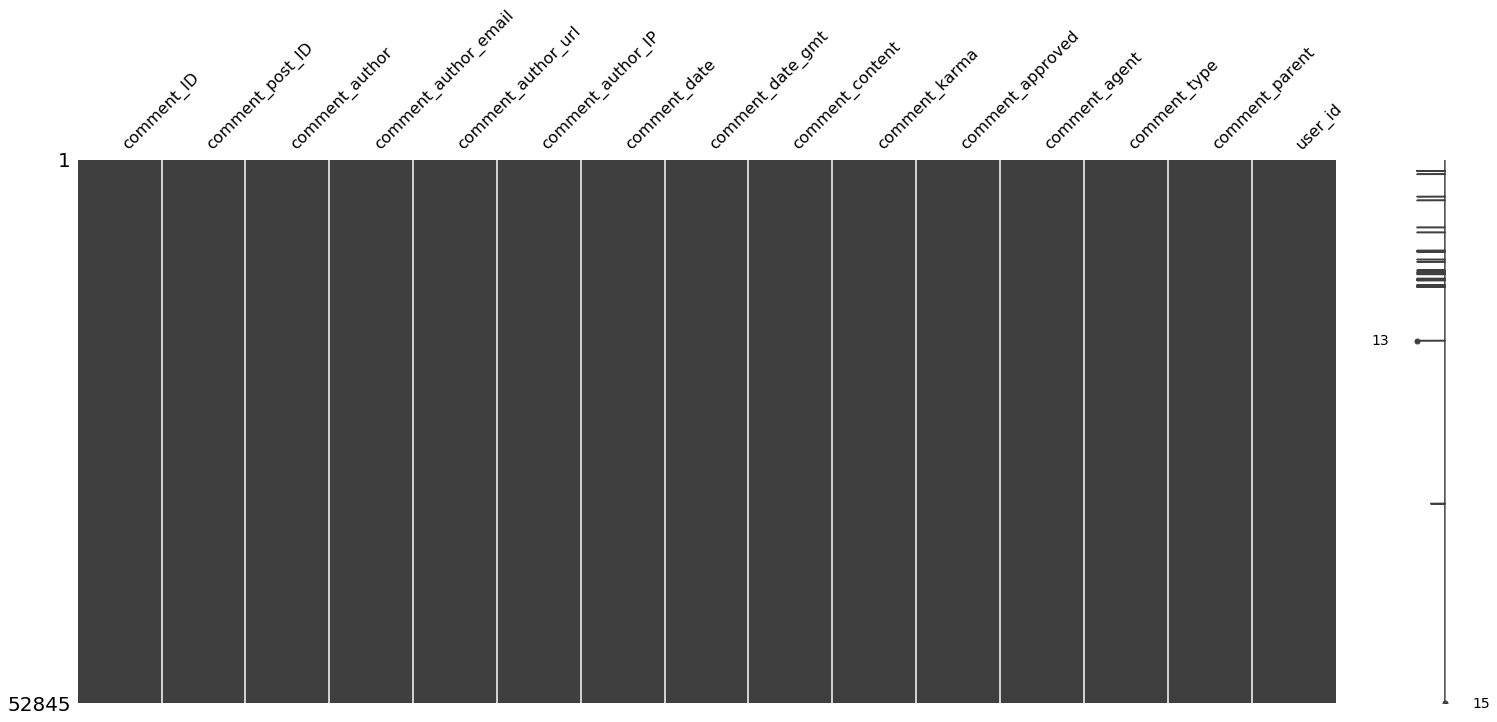

In [9]:
# Lets visualize missing values:
msno.matrix(comments)

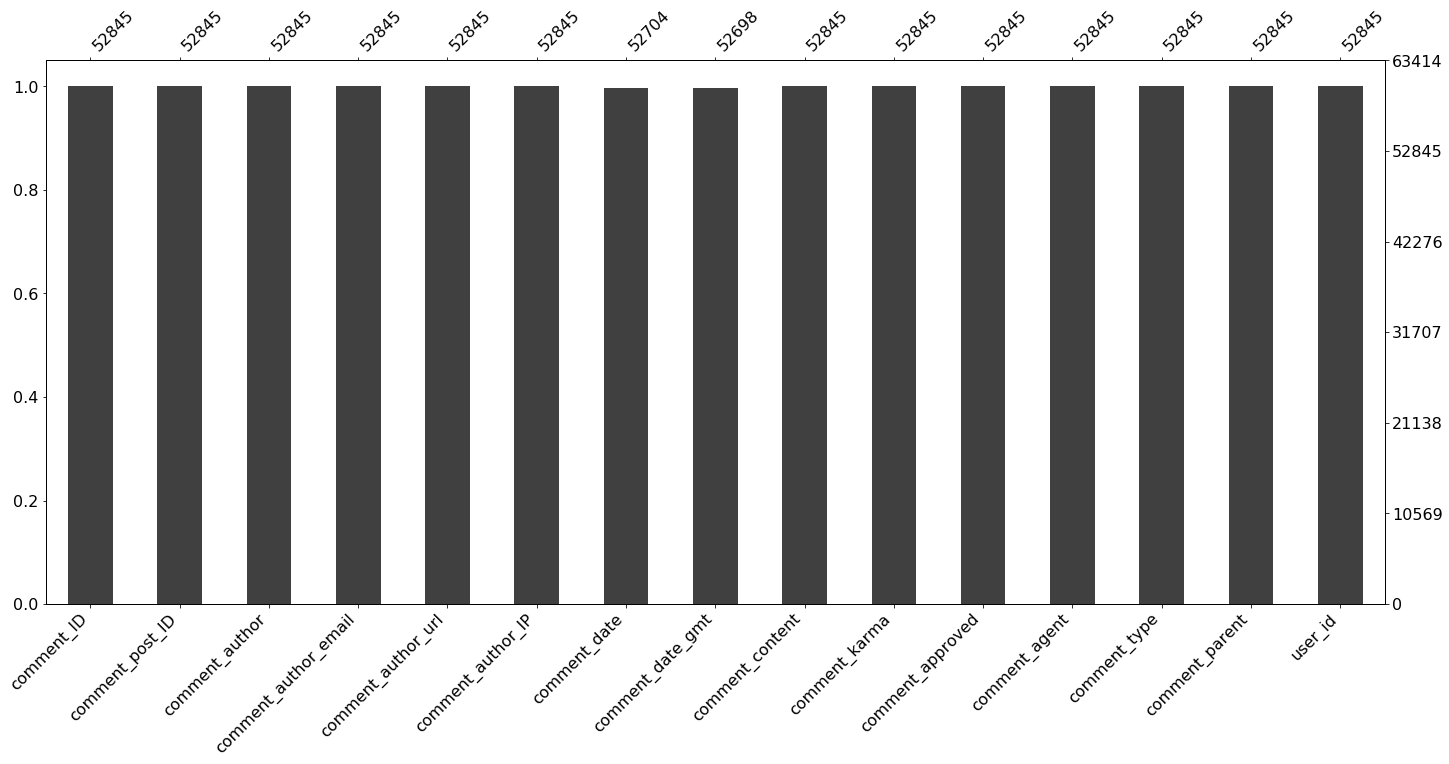

In [10]:
msno.bar(comments)

In [11]:
comments.comment_type.unique()

array(['', 'pingback'], dtype=object)

In [12]:
comments.groupby('comment_type').count()

,comment_ID,comment_post_ID,comment_author,comment_author_email,comment_author_url,comment_author_IP,comment_date,comment_date_gmt,comment_content,comment_karma,comment_approved,comment_agent,comment_parent,user_id
comment_type,,,,,,,,,,,,,,
,52794,52794,52794,52794,52794,52794,52653,52647,52794,52794,52794,52794,52794,52794
pingback,51,51,51,51,51,51,51,51,51,51,51,51,51,51


In [13]:
# find out how many response by purl bee
comments[comments['comment_author'] == 'purl bee'].count()

comment_ID              3913
comment_post_ID         3913
comment_author          3913
comment_author_email    3913
comment_author_url      3913
comment_author_IP       3913
comment_date            3911
comment_date_gmt        3911
comment_content         3913
comment_karma           3913
comment_approved        3913
comment_agent           3913
comment_type            3913
comment_parent          3913
user_id                 3913
dtype: int64

In [14]:
# lets drop columns we don't need
columns = ['comment_karma', 'comment_agent', 'comment_type', 'comment_parent', 'user_id']
cleaned_comments = comments.drop(columns, axis=1)

In [15]:
# get rid of spam comments
spam = ['0', 'post-trashed', 'spam', 'trash']
cleaned_comments = cleaned_comments[cleaned_comments.comment_approved != 0]
cleaned_comments = cleaned_comments[cleaned_comments.comment_approved != 'post-trashed']
cleaned_comments = cleaned_comments[cleaned_comments.comment_approved != 'spam']
cleaned_comments = cleaned_comments[cleaned_comments.comment_approved != 'trash']


In [16]:
cleaned_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52382 entries, 0 to 52844
Data columns (total 10 columns):
comment_ID              52382 non-null int64
comment_post_ID         52382 non-null int64
comment_author          52382 non-null object
comment_author_email    52382 non-null object
comment_author_url      52382 non-null object
comment_author_IP       52382 non-null object
comment_date            52241 non-null datetime64[ns]
comment_date_gmt        52235 non-null datetime64[ns]
comment_content         52382 non-null object
comment_approved        52382 non-null object
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 4.4+ MB


In [17]:
cleaned_comments.comment_approved.unique()

array(['1', '0'], dtype=object)

In [18]:
cleaned_comments.comment_approved.value_counts()

1    52363
0       19
Name: comment_approved, dtype: int64

In [19]:
# lets removed rows that contain response to each of the comments: 

comment_wo_response = cleaned_comments[cleaned_comments.comment_author != 'purl bee']

In [20]:
comment_wo_response.count()

comment_ID              48469
comment_post_ID         48469
comment_author          48469
comment_author_email    48469
comment_author_url      48469
comment_author_IP       48469
comment_date            48330
comment_date_gmt        48324
comment_content         48469
comment_approved        48469
dtype: int64

In [21]:
comment_wo_response.comment_author.value_counts().head()

Cassy     2756
Adam      2312
Molly     1550
Laura     1413
Kumeko     959
Name: comment_author, dtype: int64

In [22]:
# Since Cassy is an employee, we want to drop rows with responses.  
comment_wo_response[comment_wo_response['comment_author'] == 'Cassy'].head(10)

,comment_ID,comment_post_ID,comment_author,comment_author_email,comment_author_url,comment_author_IP,comment_date,comment_date_gmt,comment_content,comment_approved
1693,1703,1141,Cassy,cassandra.dominick@gmail.com,http://knitthehellout.com,130.184.236.182,2013-10-08 15:24:56,2013-10-08 15:24:56,Ha! I was one of those early people.When I enc...,1
16147,16439,6145,Cassy,,,,2011-04-16 00:00:00,2011-04-16 00:00:00,Thank you for this cute pattern. Here is the f...,1
35674,90513,746,Cassy,Cassy.guthrie@gmail.com,,166.137.136.49,2016-01-16 00:28:24,2016-01-16 05:28:24,I am in the middle of making this hat for my n...,1
35704,90562,19172,Cassy,cassy@purlsoho.com,,69.126.52.97,2016-01-17 19:15:57,2016-01-18 00:15:57,"Hi Mary Anne,\n\nWe'd be happy to help you mak...",1
35706,90564,27563,Cassy,cassy@purlsoho.com,,69.126.52.97,2016-01-17 21:14:05,2016-01-18 02:14:05,"Hi Billie,\n\nThank you for writing in! We do ...",1
35736,90605,709,Cassy,cassy@purlsoho.com,,69.126.52.97,2016-01-18 17:41:08,2016-01-18 22:41:08,"Hi Elizabeth,\n\nThanks for writing in. If you...",1
35738,90607,20978,Cassy,cassy@purlsoho.com,,69.126.52.97,2016-01-18 17:58:35,2016-01-18 22:58:35,"Hi Irene,\n\nThanks for writing in! We are hap...",1
35739,90608,1107,Cassy,cassy@purlsoho.com,,69.126.52.97,2016-01-18 18:16:17,2016-01-18 23:16:17,"Hi Margo,\n\nThanks for your question! We carr...",1
35740,90610,15348,Cassy,cassy@purlsoho.com,,69.126.52.97,2016-01-18 18:21:52,2016-01-18 23:21:52,"Hi Claudia,\n\nThanks for writing in! We do h...",1
35741,90612,2865,Cassy,cassy@purlsoho.com,,69.126.52.97,2016-01-18 18:32:26,2016-01-18 23:32:26,"Hi Kassy,\n\nThanks for writing in! For this ...",1


In [23]:
# not all comments response have purl bee, need to get rid off comment 
# author email that has @purlsoho.com

comment_wo_response = comment_wo_response[comment_wo_response['comment_author_email'].str.contains("@purlsoho.com")==False]

In [24]:
# who has the most comments?
comment_wo_response.comment_author.value_counts().head()

Sarah    305
Lisa     205
Laura    189
Susan    188
Karen    171
Name: comment_author, dtype: int64

In [25]:
# let see how many Sarah are there!
comment_wo_response[comment_wo_response['comment_author'] == 'Sarah'].head()

,comment_ID,comment_post_ID,comment_author,comment_author_email,comment_author_url,comment_author_IP,comment_date,comment_date_gmt,comment_content,comment_approved
175,177,172,Sarah,Sarahvheath@gmail.com,,99.246.176.139,2014-06-14 02:39:00,2014-06-14 02:39:00,Just made one tonight and there will definitel...,1
291,294,286,Sarah,sarahphilip@runbox.com,,24.193.100.246,2014-05-22 20:57:34,2014-05-22 20:57:34,Can I slip the first knit stitch for a cleaner...,1
294,297,286,Sarah,S.seago@me.com,,24.8.144.188,2014-05-22 23:55:43,2014-05-22 23:55:43,Is there a reason that you used the Addi Rocke...,1
314,317,286,Sarah,S.seago@me.com,,24.8.144.188,2014-07-04 03:07:14,2014-07-04 03:07:14,I&#39;ve been trying to get this project going...,1
751,759,647,Sarah,sarahwjagger@gmail.com,http://www.goingstarfishing.blogspot.com,72.200.155.202,2014-03-22 14:20:12,2014-03-22 14:20:12,"Hi Corinne,<br/><br/>Wondering- do you have an...",1


In [26]:
comment_wo_response[comment_wo_response['comment_author_email'].str.contains('@purl')]

,comment_ID,comment_post_ID,comment_author,comment_author_email,comment_author_url,comment_author_IP,comment_date,comment_date_gmt,comment_content,comment_approved


In [27]:
# before we move forward with comment sentitment, lets clean it up the txt
# comment content.  


def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

cleaned_comment_df = standardize_text(comment_wo_response, 'comment_content')
cleaned_comment_df.to_csv('cleaned_comment_df.csv')
cleaned_comment_df.head()

,comment_ID,comment_post_ID,comment_author,comment_author_email,comment_author_url,comment_author_IP,comment_date,comment_date_gmt,comment_content,comment_approved
0,2,23,emily p,,,70.44.66.3,2014-07-24 12:54:46,2014-07-24 12:54:46,these are fantastic! i have been looking for s...,1
1,3,23,Lena,lena.mumen@gmail.com,http://www.mrsgarlichead.com,85.1.237.251,2014-07-24 13:24:02,2014-07-24 13:24:02,"oh these are lovely i love the tulip hem, i h...",1
2,4,23,Katie,,,72.198.169.59,2014-07-24 15:33:46,2014-07-24 15:33:46,love these shorts!! this may be a silly questi...,1
3,5,23,jessica,,,76.114.88.227,2014-07-24 15:46:05,2014-07-24 15:46:05,"so sad, yet another pattern not big enough for...",1
4,6,23,"Margo, Thrift at Home",thriftathome@gmail.com,http://thriftathome.blogspot.com,108.55.66.48,2014-07-24 18:19:31,2014-07-24 18:19:31,yes i am done with the gym!!! this year i 39 ...,1


In [28]:
# use TexBlobs' sentiment analysis.  

comment = cleaned_comment_df.comment_content

def sentiment_analysis(comment):
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1


In [30]:
cleaned_comment_df['sentiment'] = np.array([sentiment_analysis(comment) for comment in cleaned_comment_df.comment_content])

In [31]:
cleaned_comment_df.sentiment.value_counts()

 1    28399
-1     3724
 0     2995
Name: sentiment, dtype: int64

In [32]:
def sentiment_polarity(comment):
    analysis = TextBlob(comment)
    return analysis.sentiment.polarity

In [33]:
cleaned_comment_df['sentiment_values'] = np.array([sentiment_polarity(comment) for comment in cleaned_comment_df.comment_content])

In [34]:
cleaned_comment_df.sentiment_values.describe()

count    35118.000000
mean         0.254531
std          0.257722
min         -1.000000
25%          0.063316
50%          0.229167
75%          0.408333
max          1.000000
Name: sentiment_values, dtype: float64

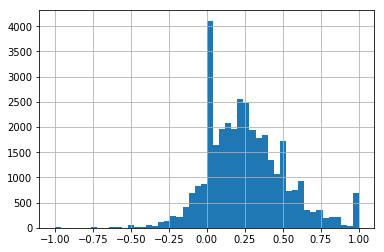

In [35]:
# plotting distribution sentiment for each comment
cleaned_comment_df.sentiment_values.hist(bins=50)

In [36]:
# find the average length of each comment
mean = np.mean(cleaned_comment_df.comment_content.str.len())

In [37]:
print("The length's average for each comment: {}".format(mean))

The length's average for each comment: 206.12754143174442


In [38]:
dist = cleaned_comment_df.comment_content.describe()

In [39]:
print('The distribution is: {}'.format(dist))

The distribution is: count          35118
unique         34774
top       thank you!
freq              39
Name: comment_content, dtype: object


In [40]:
from os import path

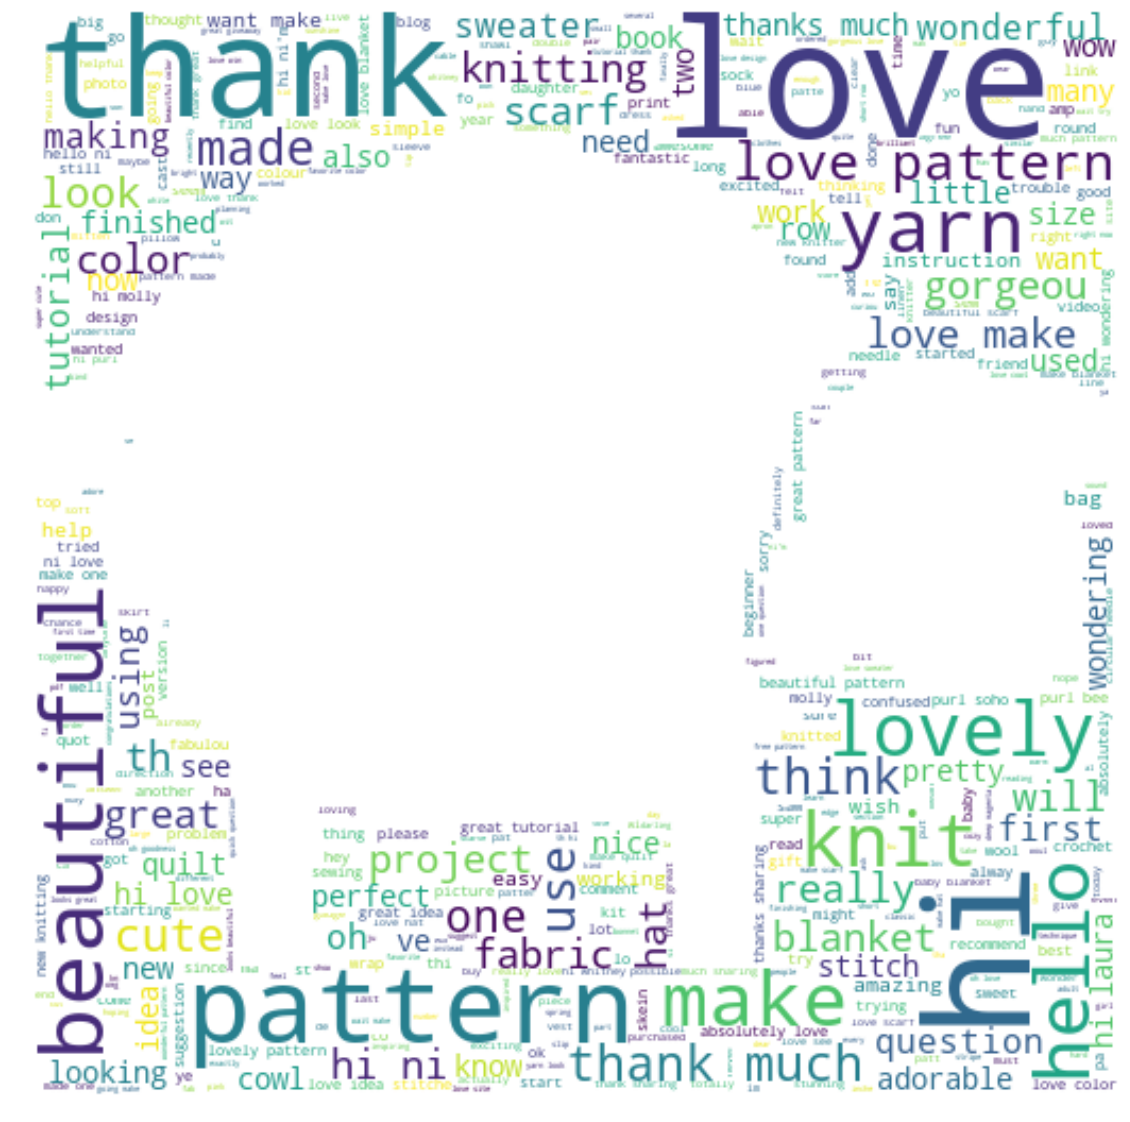

In [41]:
sheep = np.array(Image.open(path.join('black.png')))
stopwords = set(STOPWORDS)
stopwords.add('br')

wc = WordCloud(background_color='white', max_words=2000, mask=sheep, 
               stopwords=stopwords, width=400, height=200)
data = comment.to_string()

wc.generate(data)
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
# plt.figure(figsize=(20, 20))
# plt.imshow(sheep, cmap=plt.cm.gray, interpolation='bilinear')
# # plt.axis('off')
plt.show()

In [42]:
# from wordcloud import ImageColorGenerator
# purl_coloring = np.array(Image.open(path.join('purlbundles.png')))
# stopwords = set(STOPWORDS)
# stopwords.add('br')

# wc = WordCloud(background_color='white', max_words=2000, mask=purl_coloring, 
#                stopwords=stopwords)
# data = comment.to_string()

# image_colors = ImageColorGenerator(purl_coloring)

# wc.generate(data)

# plt.figure(figsize=(20, 20))
# plt.imshow(wc, interpolation='bilinear')
# plt.axis('off')

# plt.figure(figsize=(20, 20))
# plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
# plt.axis('off')

# plt.figure()
# plt.imshow(purl_coloring, cmap=plt.cm.gray, interpolation='bilinear')
# plt.axis('off')
# plt.show()

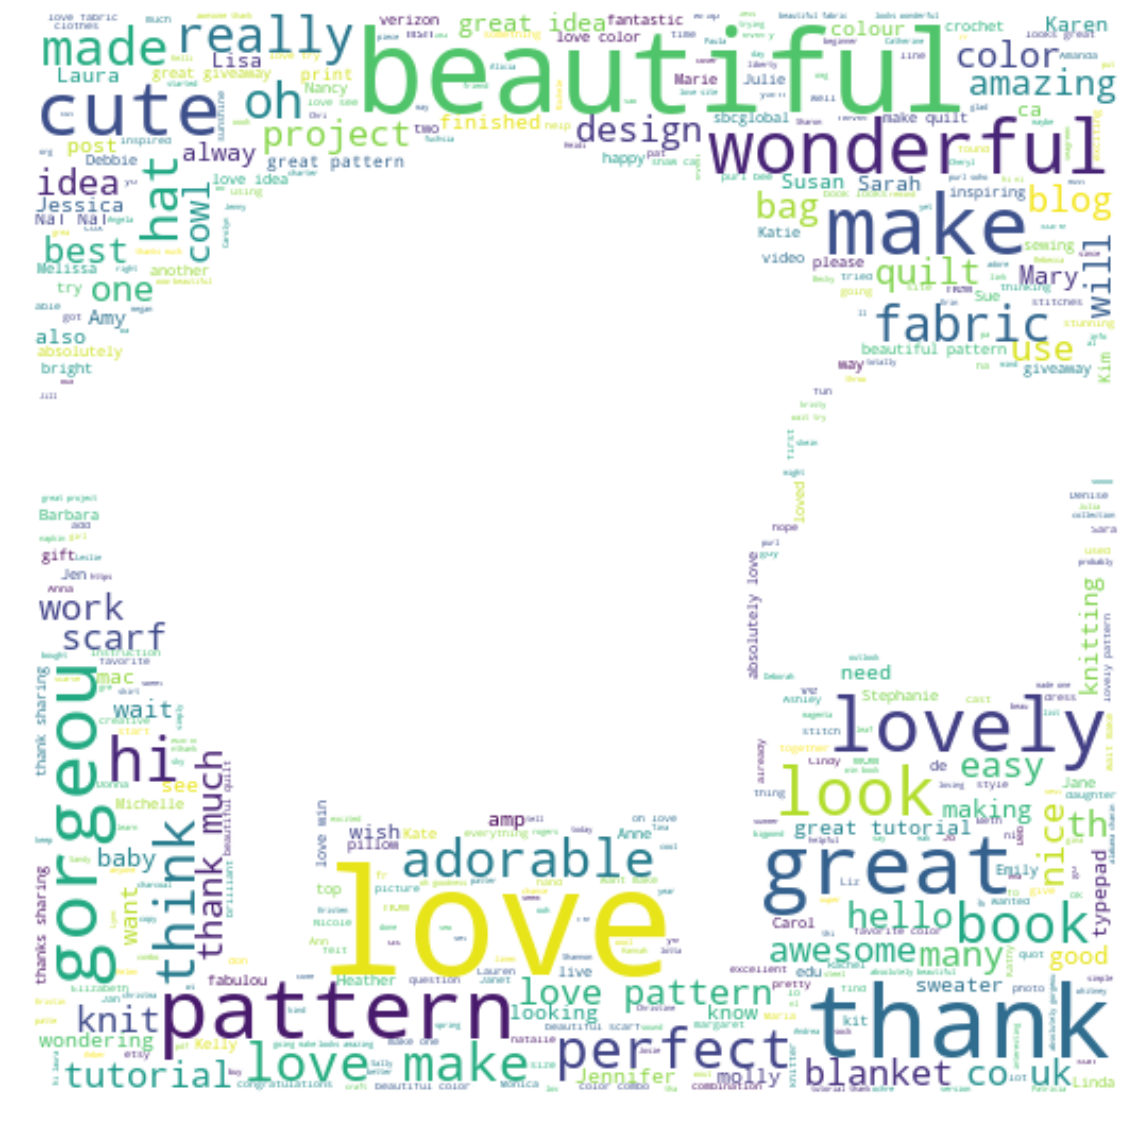

In [43]:
sheep = np.array(Image.open(path.join('black.png')))
stopwords = set(STOPWORDS)
stopwords.add('br')
stopwords.add('gmail')
stopwords.add('yahoo')
stopwords.add('comcast')
stopwords.add('hotmail')
stopwords.add('blogspot')
stopwords.add("aol")
stopwords.add('net')
stopwords.add('att')
stopwords.add('wordpress')


wc = WordCloud(background_color='white', max_words=2000, mask=sheep, 
               stopwords=stopwords, width=400, height=200)
positive_data = cleaned_comment_df[cleaned_comment_df['sentiment_values'] >= 0.5].to_string()

wc.generate(positive_data)
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
# plt.figure(figsize=(20, 20))
# plt.imshow(sheep, cmap=plt.cm.gray, interpolation='bilinear')
# # plt.axis('off')
plt.show()

In [45]:
cleaned_comment_df.to_csv('cleaned_comment_df.csv')

## Lets perform some ML 

In [75]:
#bag of words:
ml_df = pd.read_csv('cleaned_comment_df.csv', index_col=0)

In [76]:
ml_df.head()

,comment_ID,comment_post_ID,comment_author,comment_author_email,comment_author_url,comment_author_IP,comment_date,comment_date_gmt,comment_content,comment_approved,sentiment,sentiment_values
0,2,23,emily p,NaN,NaN,70.44.66.3,2014-07-24 12:54:46,2014-07-24 12:54:46,these are fantastic! i have been looking for s...,1,1,0.781250
1,3,23,Lena,lena.mumen@gmail.com,http://www.mrsgarlichead.com,85.1.237.251,2014-07-24 13:24:02,2014-07-24 13:24:02,"oh these are lovely i love the tulip hem, i h...",1,1,0.375000
2,4,23,Katie,NaN,NaN,72.198.169.59,2014-07-24 15:33:46,2014-07-24 15:33:46,love these shorts!! this may be a silly questi...,1,1,0.232292
3,5,23,jessica,NaN,NaN,76.114.88.227,2014-07-24 15:46:05,2014-07-24 15:46:05,"so sad, yet another pattern not big enough for...",1,-1,-0.166667
4,6,23,"Margo, Thrift at Home",thriftathome@gmail.com,http://thriftathome.blogspot.com,108.55.66.48,2014-07-24 18:19:31,2014-07-24 18:19:31,yes i am done with the gym!!! this year i 39 ...,1,0,0.000000


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = ml_df["comment_content"].tolist()
list_labels = ml_df["sentiment"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

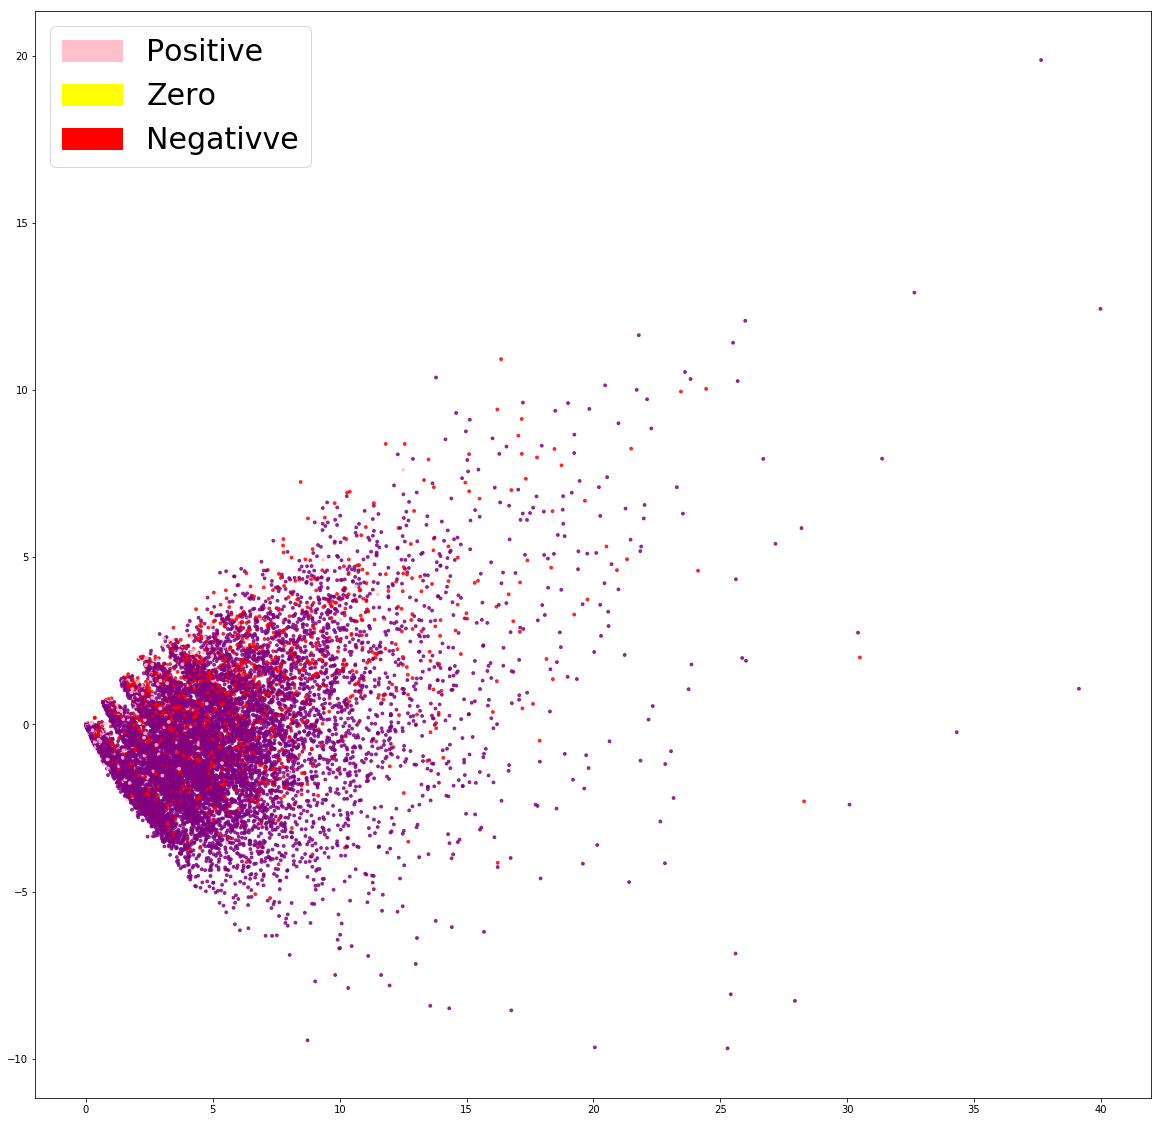

In [97]:
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath='Purl_pca.csv', plot=True):
    lsa = TruncatedSVD(n_components=3)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['red', 'yellow', 'pink', 'purple']
    if plot:
        plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=8, alpha=.8, c=test_labels,
                   cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='pink', label='Positive')
        yellow_patch = mpatches.Patch(color = 'yellow', label='Zero')
        green_patch = mpatches.Patch(color='red', label='Negativve')
        plt.legend(handles=[red_patch, yellow_patch, green_patch],
                  prop={'size': 30})
        
fig = plt.figure(figsize=(20, 20))
plot_LSA(X_train_counts, y_train)
plt.show()
        

In [98]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

## Lets evaluate

In [99]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report


def get_metrics(y_test, y_predicted):
    precision = precision_score(y_test, y_predicted, pos_label=None,
                               average='weighted')
    
    recall = recall_score(y_test, y_predicted, pos_label=None,
                         average='weighted')
    
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)

print("Accuracy = {}, precision = {}, recall = {}, f1 = {}".format(accuracy,precision, recall, f1))
                                                                      

Accuracy = 0.9249715261958997, precision = 0.9295632125312356, recall = 0.9249715261958997, f1 = 0.926416710483042


In [100]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

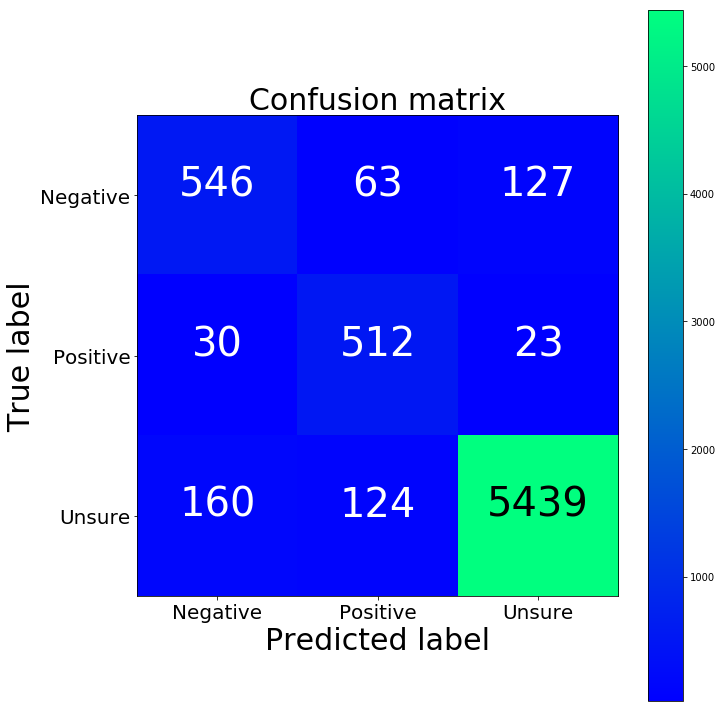

[[ 546   63  127]
 [  30  512   23]
 [ 160  124 5439]]


In [101]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

# why the latter?

In [102]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

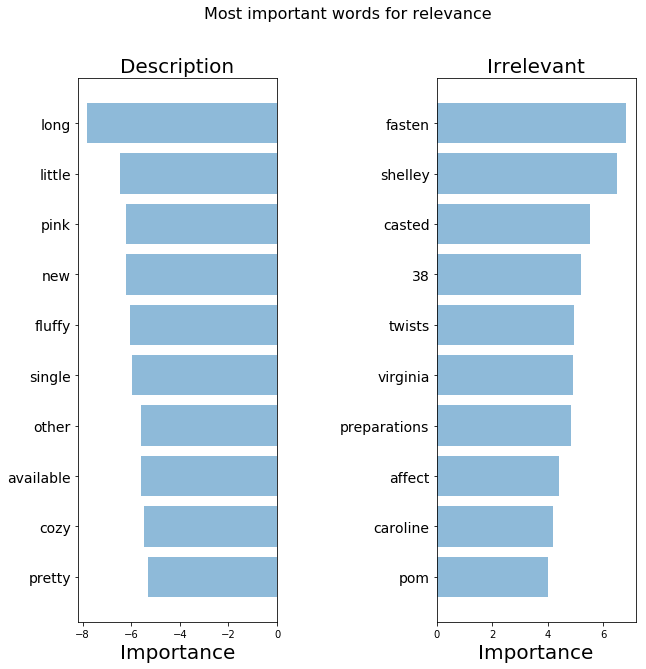

In [104]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Description', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [105]:
# TFIDF bag of words

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

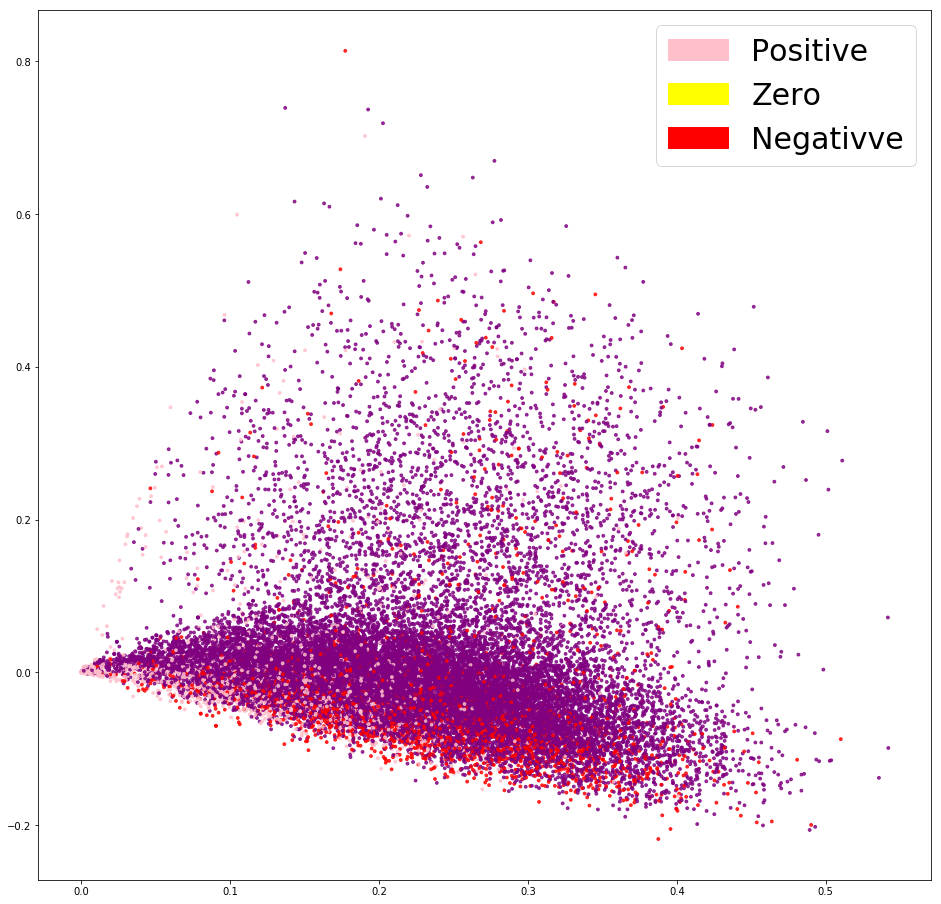

In [106]:
fit = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [107]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [108]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)

print("Accuracy = {}, precision = {}, recall = {}, f1 = {}".format(accuracy_tfidf,precision_tfidf, recall_tfidf, f1_tfidf))

Accuracy = 0.9178530751708428, precision = 0.9267664052762155, recall = 0.9178530751708428, f1 = 0.920882012897978


In [112]:
ml_df.to_csv('PURL_NLP_ML.csv')

# Clusering

In [113]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


In [114]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [115]:
stop_words = text.ENGLISH_STOP_WORDS.union(["'s", "mr.", "let", "come"])
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                   max_features=100000,
                                   min_df=0.2,
                                   stop_words=stop_words,
                                   use_idf=True,
                                   tokenizer=tokenize_and_stem,
                                   ngram_range=(1, 3))

In [118]:
clustering_df = pd.read_csv('PURL_NLP_ML.csv')
synopses = list(cleaned_comment_df['comment_content'])
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

(35118, 4)


In [123]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [124]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index=totalvocab_stemmed)
print('There are ' + str(vocab_frame.shape[0]) + ' item in vocab_frame')

There are 1373043 item in vocab_frame


In [125]:
terms = tfidf_vectorizer.get_feature_names()

In [126]:
# from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(tfidf_matrix)


In [127]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

clustering_df['clusters'] = clusters



CPU times: user 2.21 s, sys: 27.7 ms, total: 2.24 s
Wall time: 2.28 s


In [128]:
centroid_ordered = km.cluster_centers_.argsort()[:, ::-1]

cluster_words = {}
for i in range(num_clusters):
    cluster_words[i] = []
    for ind in centroid_ordered[i, :20]:
        cluster_words[i].append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
cluster_words_df = pd.DataFrame.from_dict(cluster_words, orient='index')
cluster_words_df

,0,1,2,3
0,pattern,thank,lovely,make
1,thank,pattern,make,lovely
2,lovely,thank,make,pattern
3,thank,pattern,make,lovely
4,make,thank,lovely,pattern


In [130]:
clustering_df['clusters'].value_counts()

0    8504
1    8492
4    6598
3    6143
2    5381
Name: clusters, dtype: int64

In [131]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
 
centroid_ordered

for i in range(num_clusters):
    print("Cluster {} words:".format(i, end=''))
    
    for ind in centroid_ordered[i, :5]: #replace 5 with n words per cluster
        print(' {} '.format(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=','))    
    print() #add whitespace
    print() #add whitespace
    
#     print("Cluster {} comment_content:".format(i, end=''))
#     for title in clean_comment_df.ix[i]['comment_content']:
#         print(' {},'.format(title, end=''))
#     print() #add whitespace
#     print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words:
 b'pattern' 
 b'thank' 
 b'lovely' 
 b'make' 

/Users/tomasespina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()





Cluster 1 words:
 b'thank' 
 b'pattern' 
 b'make' 
 b'lovely' 


Cluster 2 words:
 b'lovely' 
 b'thank' 
 b'make' 
 b'pattern' 


Cluster 3 words:
 b'thank' 
 b'pattern' 
 b'make' 
 b'lovely' 


Cluster 4 words:
 b'make' 
 b'thank' 
 b'lovely' 
 b'pattern' 






In [132]:
clustering_df.to_csv('PURL_NLP_Custering_df.csv')

In [144]:
# import os  # for os.path.basename

# import matplotlib.pyplot as plt
# import matplotlib as mpl

# from sklearn.manifold import MDS

# MDS()

# # convert two components as we're plotting points in a two-dimensional plane
# # "precomputed" because we provide a distance matrix
# # we will also specify `random_state` so the plot is reproducible.
# mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

# pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

# xs, ys = pos[:, 0], pos[:, 1]
# print()
# print()

In [133]:
clustering_df.head()

,Unnamed: 0,comment_ID,comment_post_ID,comment_author,comment_author_email,comment_author_url,comment_author_IP,comment_date,comment_date_gmt,comment_content,comment_approved,sentiment,sentiment_values,clusters
0,0,2,23,emily p,NaN,NaN,70.44.66.3,2014-07-24 12:54:46,2014-07-24 12:54:46,these are fantastic! i have been looking for s...,1,1,0.781250,3
1,1,3,23,Lena,lena.mumen@gmail.com,http://www.mrsgarlichead.com,85.1.237.251,2014-07-24 13:24:02,2014-07-24 13:24:02,"oh these are lovely i love the tulip hem, i h...",1,1,0.375000,2
2,2,4,23,Katie,NaN,NaN,72.198.169.59,2014-07-24 15:33:46,2014-07-24 15:33:46,love these shorts!! this may be a silly questi...,1,1,0.232292,4
3,3,5,23,jessica,NaN,NaN,76.114.88.227,2014-07-24 15:46:05,2014-07-24 15:46:05,"so sad, yet another pattern not big enough for...",1,-1,-0.166667,0
4,4,6,23,"Margo, Thrift at Home",thriftathome@gmail.com,http://thriftathome.blogspot.com,108.55.66.48,2014-07-24 18:19:31,2014-07-24 18:19:31,yes i am done with the gym!!! this year i 39 ...,1,0,0.000000,4
